## N-body graph networks for Peter W. Battaglia et. al, 2016

In [13]:
import math, copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [14]:
# Simulation parameters
total_state = 1000 #  number of time steps
fea_num = 5 # number of features [mass,x,y,x_vel,y_vel]
G = 1 # gravitational constant
diff_t = 0.01 # time step

# Graph network parameters
Ds = 5 # the state dimension
No = 6 # the number of objects
Nr = 30 # the number of relations
Dr = 1 # the relationship dimension
Dx = 1 # the external effect dimension
De = 50 # the effect dimension
Dp = 2 # the object modeling output dimension
Da = 1 # the abstract modeling output dimension

In [15]:
# Nbody Simulation System

def cal_force(reciever,sender):
    """ calculate force between two objects
    """
    diff = sender[1:3]-reciever[1:3]
    dist = np.sqrt(np.sum(diff**2))
    return G*reciever[0]*sender[0]/(max(0.1, dist)**3)*diff
 
def next_step(cur_state,n_body):
    """ update positions & velocities after diff_t
    """
    next_state = np.zeros((n_body,fea_num),dtype=float)
    for i in range(n_body):
        force = 0.0
        for j in range(n_body):
            if j==i: continue
            force += cal_force(cur_state[i],cur_state[j]) 
        acc = force/cur_state[i][0]
        next_state[i][0] = cur_state[i][0];
        next_state[i][3:5] = cur_state[i][3:5]+acc*diff_t;
        next_state[i][1:3] = cur_state[i][1:3]+next_state[i][3:5]*diff_t;
    return next_state;

def simulation(n_body):
    """ generate a n-body simulation
    """
    data=np.zeros((total_state,n_body,fea_num),dtype=float)
    data[0][0] = [5, 0, 0, 0, 0.]
    for i in range(1,n_body):
        data[0][i][0] = np.random.rand()+1.0
        dist = np.random.rand()*10.0 
        theta_rad = math.radians(np.random.rand()*360.)
        data[0][i][1] = dist*np.cos(theta_rad)
        data[0][i][2] = dist*np.sin(theta_rad)
        data[0][i][3] = -np.cos(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
        data[0][i][4] = np.sin(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
    for i in range(1,total_state):
        data[i]=next_step(data[i-1],n_body);
    return data

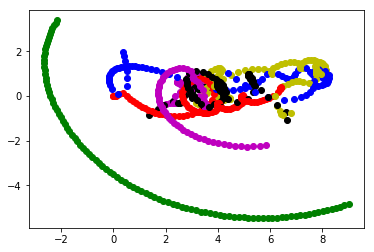

In [16]:
# An example of Nbody system: No-> number of objects
xy = simulation(No)[:, :, 1:3]
color=['ro','bo','go','ko','yo','mo','co']
for i in range(len(xy)):
    if i%10 != 0: continue
    for j in range(xy.shape[1]):
        plt.plot(xy[i,j,1], xy[i,j,0], color[j%len(color)])

In [17]:
# Data Preparation for graph-net

set_num = 10
total_data = np.zeros(((total_state-1)*set_num, Ds, No), dtype=object)
total_label = np.zeros(((total_state-1)*set_num, Dp, No), dtype=object)
for i in range(set_num):
    raw_data = simulation(No)
    data = np.zeros((total_state-1, Ds, No), dtype=object)
    label = np.zeros((total_state-1, Dp, No), dtype=object)
    for j in range(total_state-1):
        data[j] = np.transpose(raw_data[j])
        label[j] = np.transpose(raw_data[j+1,:,3:5])
    total_data[i*(total_state-1):(i+1)*(total_state-1),:] = data
    total_label[i*(total_state-1):(i+1)*(total_state-1),:] = label

# Training/Validation/Test Split
train_data, test_data, train_label, test_label = train_test_split(total_data, 
                        total_label, test_size=0.1, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, 
                        train_label, test_size=0.1, shuffle=True)


mini_batch = 100
# Set Rr_data, Rs_data, Ra_data and X_data
Rr_data = np.zeros((mini_batch, No, Nr), dtype=float)
Rs_data = np.zeros((mini_batch, No, Nr), dtype=float)
Ra_data = np.zeros((mini_batch, Dr, Nr), dtype=float) 
X_data = np.zeros((mini_batch, Dx, No), dtype=float)

cnt=0
for i in range(No):
    for j in range(No):
        if i==j: continue
        Rr_data[:, i, cnt] = 1.0
        Rs_data[:, j, cnt] = 1.0
        cnt += 1


In [18]:
# Construct graph-network
# IN(G) = phi_O(a(G, X, phi_R(m(G))))

def m(O,Rr,Rs,Ra):
    """ Marshalling function, rearranges the objects and relations into
    interaction terms.
    Output dimension: (2*Ds + Dr)*Nr
    """
    return tf.concat([(tf.matmul(O,Rr)-tf.matmul(O,Rs)),Ra],1)
  
def phi_R(B):
    """ B is input to phi_R, which applies an MLP to each column.
    Output is a distributed representation of the relation with size De.
    Ouput dimension: De * Nr
    """
    B_trans = tf.transpose(B, [0, 2, 1])
    B_trans = tf.reshape(B_trans, [-1, Ds+Dr])
    
    h_size = 100
    w1 = tf.Variable(tf.truncated_normal([Ds+Dr, h_size], stddev=0.1), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(B_trans, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    
    w3 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h3 = tf.nn.relu(tf.matmul(h2, w3) + b3)
    
    w4 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32)
    b4 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h4 = tf.nn.relu(tf.matmul(h3, w4) + b4)
    
    w5 = tf.Variable(tf.truncated_normal([h_size, De], stddev=0.1), dtype=tf.float32)
    b5 = tf.Variable(tf.zeros([De]), dtype=tf.float32)
    h5 = tf.matmul(h4, w5) + b5
    
    h5_trans=tf.reshape(h5,[-1, Nr, De])
    h5_trans=tf.transpose(h5_trans,[0,2,1])
    return (h5_trans)

def a(O,Rr,X,E):
    """ Aggregation function: collects all effects that apply to each receiver
    object, merges them, and combine them with O and X to form a set of object model 
    inputs, one per object. No columns represent the object states, external effects, 
    and per-object aggregate interaction effects.
    Output dimension: (Ds+Dx+De)*No
    """
    E_bar=tf.matmul(E,tf.transpose(Rr,[0,2,1]));
    O_2=tf.stack(tf.unstack(O, Ds,1)[3:5],1);
    return (tf.concat([O_2,X,E_bar],1));

def phi_O(C):
    """C applies to another MLP, to each of the No columns.
    Output size: Dp.
    """
    C_trans=tf.transpose(C,[0,2,1]);
    C_trans=tf.reshape(C_trans,[-1,2+Dx+De])
    
    h_size=100
    w1 = tf.Variable(tf.truncated_normal([(2+Dx+De), h_size], stddev=0.1),dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), name="o_b1", dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(C_trans, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size,Dp], stddev=0.1),dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([Dp]), dtype=tf.float32)
    h2 = tf.matmul(h1, w2) + b2
    
    h2_trans=tf.reshape(h2,[-1, No, Dp])
    h2_trans=tf.transpose(h2_trans,[0,2,1])
    return(h2_trans)

def phi_A(P):
    """ To infer abstract properties of a system, an additional phi_A is appended.
    which represents an abstract, global property of the system
    """
    p_bar = tf.reduce_sum(P,2)
    
    h_size=25
    w1 = tf.Variable(tf.truncated_normal([Dp, h_size], stddev=0.1), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(p_bar, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size,  Da], stddev=0.1), dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([Da]), dtype=tf.float32)
    h2 = tf.matmul(h1, w2) + b2
    return (h2)
  

In [19]:
# Object Matrix
O = tf.placeholder(tf.float32, [None,Ds,No], name="O")

# Relation Matrics R=<Rr,Rs,Ra>
Rr = tf.placeholder(tf.float32, [None,No,Nr], name="Rr")
Rs = tf.placeholder(tf.float32, [None,No,Nr], name="Rs")
Ra = tf.placeholder(tf.float32, [None,Dr,Nr], name="Ra")

# next velocities
P_label = tf.placeholder(tf.float32, [None,Dp,No], name="P_label")

# External Effects
X = tf.placeholder(tf.float32, [None,Dx,No], name="X")

# marshalling function, m(G)=B, G=<O,R>  
B = m(O, Rr, Rs, Ra)

# relational modeling phi_R(B)=E
E = phi_R(B)

# aggregator
C = a(O, Rr, X, E)

# object modeling phi_O(C)=P
P = phi_O(C)

# abstract modeling phi_A(P)=q
#q=phi_A(P)

In [22]:
# loss and optimizer
params_list = tf.global_variables()
mse = tf.reduce_mean(tf.reduce_mean(tf.square(P-P_label), [1,2]))

loss = 0.001*tf.nn.l2_loss(E)
for param in params_list:
    loss += 0.001*tf.nn.l2_loss(param)
    
optimizer = tf.train.AdamOptimizer(0.001)
trainer = optimizer.minimize(mse + loss)

# Training
max_epoches = 10

sess = tf.Session()
tf.global_variables_initializer().run()


for i in range(max_epoches):
    tr_loss=0;
    for j in range(int(len(train_data)/mini_batch)):
        batch_data = train_data[j*mini_batch:(j+1)*mini_batch]
        batch_label = train_label[j*mini_batch:(j+1)*mini_batch]
        tr_loss_part, _= sess.run([mse,trainer], \
            feed_dict = {O:batch_data, Rr:Rr_data, Rs:Rs_data, \
                         Ra:Ra_data, P_label: batch_label,X:X_data});
        tr_loss += tr_loss_part

    train_idx = list(range(len(train_data)))
    np.random.shuffle(train_idx)
    train_data=train_data[train_idx]
    train_label=train_label[train_idx]

    val_loss=0
    for j in range(int(len(val_data)/mini_batch)):
        batch_data = val_data[j*mini_batch:(j+1)*mini_batch]
        batch_label = val_label[j*mini_batch:(j+1)*mini_batch]
        val_loss_part, estimated = sess.run([mse, P],\
            feed_dict ={O:batch_data, Rr:Rr_data, Rs:Rs_data, \
                       Ra:Ra_data, P_label:batch_label, X:X_data})
        val_loss += val_loss_part

    val_idx = list(range(len(val_data)))
    np.random.shuffle(val_idx)
    val_data = val_data[val_idx]
    val_label = val_label[val_idx]
    print("Epoch "+str(i+1)+" Training MSE: "+str(tr_loss/(int(len(train_data)/mini_batch)))+" Validation MSE: "+str(val_loss/(j+1)));


Epoch 1 Training MSE: 0.4911743771284819 Validation MSE: 0.07673922098345226
Epoch 2 Training MSE: 0.058627260476350786 Validation MSE: 0.05432876116699643
Epoch 3 Training MSE: 0.047870791517198086 Validation MSE: 0.04772976371977064
Epoch 4 Training MSE: 0.04328696571756154 Validation MSE: 0.04417807960675822
Epoch 5 Training MSE: 0.04067574255168438 Validation MSE: 0.04289037444525295
Epoch 6 Training MSE: 0.038698469288647175 Validation MSE: 0.041180822170443006
Epoch 7 Training MSE: 0.03706012390321121 Validation MSE: 0.0401110015809536
Epoch 8 Training MSE: 0.03631664637941867 Validation MSE: 0.038250204589631825
Epoch 9 Training MSE: 0.035239277756772935 Validation MSE: 0.03764044431348642
Epoch 10 Training MSE: 0.03452633771812543 Validation MSE: 0.03679161601596408


In [35]:
# Make Video
frame_len = 300
raw_data = simulation(No)
xy_origin = copy.deepcopy(raw_data[:frame_len,:,1:3])

estimated_data = np.zeros((frame_len, No, Ds),dtype=float)
estimated_data[0] = raw_data[0]


ts_loss=0;
for i in range(1,frame_len):
    ts_loss_part, velocities = sess.run([mse, P], \
        feed_dict={O:[np.transpose(raw_data[i-1])],Rr:[Rr_data[0]],Rs:[Rs_data[0]],\
                   Ra:[Ra_data[0]],X:[X_data[0]],P_label:[np.transpose(raw_data[i,:,3:5])]})

    velocities = velocities[0]
    estimated_data[i,:,0] = estimated_data[i-1][:,0]
    estimated_data[i,:,3:5] = np.transpose(velocities)
    estimated_data[i,:,1:3] = estimated_data[i-1,:,1:3] + estimated_data[i,:,3:5]*diff_t
    
    ts_loss += ts_loss_part
xy_estimated = estimated_data[:,:,1:3]

print("Test Loss: "+str(ts_loss));


Test Loss: 26.923588846810162


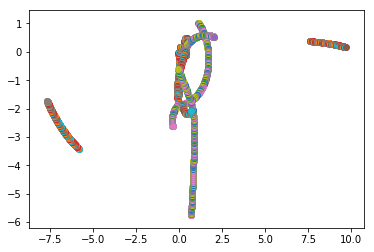

In [36]:
fig = plt.figure()
for i in range(len(xy_origin)):
    for j in range(xy_origin.shape[1]):
        plt.scatter(xy_origin[i,j,1],xy_origin[i,j,0]);

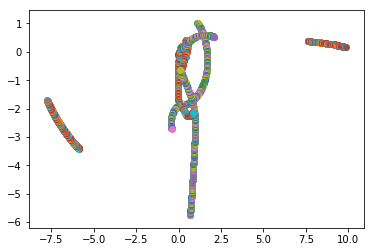

In [37]:
fig = plt.figure()
for i in range(len(xy_estimated)):
    for j in range(xy_estimated.shape[1]):
        plt.scatter(xy_estimated[i,j,1],xy_estimated[i,j,0]);